## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

## READING DATA

In [2]:
sales=pd.read_excel('sales_data.xlsx')
sales.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
date=pd.read_excel('date.xlsx')
date.head()

,timestamp,date,day_name,day_of_month,month_of_year,time_of_day(hh:mm:ss)
0,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
1,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
2,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
3,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
4,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
transaction id           541909 non-null object
product id               541909 non-null object
product description      540455 non-null object
quantity sold            541909 non-null int64
transaction timestamp    541909 non-null datetime64[ns]
unit price               541909 non-null float64
customer id              406829 non-null float64
transaction country      541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Our dataset is composed of 541909 rows and 8 columns. When going through the columns, we notice that we have some missing values in the customer id column, as it only has 406829 values. Also the product description has missing values. So, that should be considered when applying exploration to our dataset.

transaction id                0
product id                    0
product description        1454
quantity sold                 0
transaction timestamp         0
unit price                    0
customer id              135080
transaction country           0
dtype: int64


Text(0.5,1,'Ratio of missing values per columns')

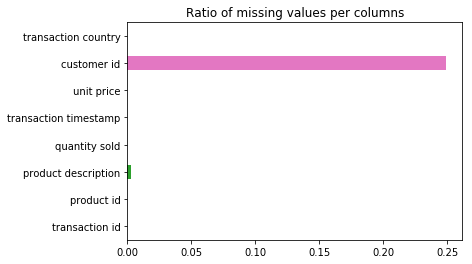

In [5]:
print(sales.isnull().sum())
sales.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [6]:
sales.describe()

,quantity sold,unit price,customer id
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### The first thing to notice is that we have some negative values in our dataset. Maybe, this could mean that these quantities (with corresponding unit price values) was returned or cancelled.

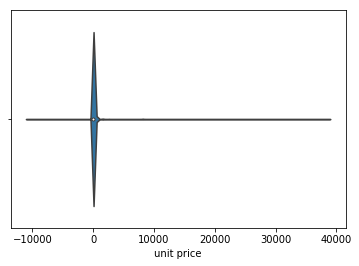

In [7]:
sns.violinplot(sales['unit price'])

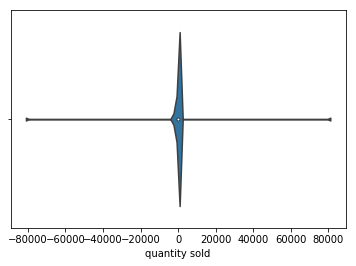

In [8]:
sns.violinplot(sales['quantity sold'])

In [9]:
sales.sort_values('customer id')[:5]

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland


### We see that for every cancelled orders have a negative quantity and every other description is same.

### Number of Cancelled Orders

In [10]:
cancelled_orders = sales[sales['transaction id'].astype(str).str.contains('C')]
cancelled_orders.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [11]:
print("We have ",len(cancelled_orders), " cancelled orders.")
#percentage of cancelled orders in total orders
total_orders = sales['transaction id'].nunique()
cancelled_number = len(cancelled_orders)
print('Percentage of orders canceled: {}/{} ({:.2f}%) '.format(cancelled_number, total_orders, cancelled_number/total_orders*100))

We have  9288  cancelled orders.
Percentage of orders canceled: 9288/25900 (35.86%) 


In [12]:
sales_f=sales[sales['quantity sold']>0]
sales_ff=sales_f[sales_f['unit price']>0]
sales_ff.describe()

,quantity sold,unit price,customer id
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


### Now we have filtered the dataset by removing negative quantities

In [13]:
sales_ff.isnull().sum()

transaction id                0
product id                    0
product description           0
quantity sold                 0
transaction timestamp         0
unit price                    0
customer id              132220
transaction country           0
dtype: int64

###  We  have null values for CustomerID for 24% of points so we will remove them as we cannot give them any arbitrary ID

In [14]:
sales_ff[sales_ff.isnull().any(axis=1)].head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [15]:
sales_ff=sales_ff.dropna()

In [16]:
sales_ff.isnull().sum()

transaction id           0
product id               0
product description      0
quantity sold            0
transaction timestamp    0
unit price               0
customer id              0
transaction country      0
dtype: int64

### Checking and Removing Duplicate Entries

In [17]:
sales_ff.duplicated().sum()

5192

In [18]:
sales_ff.drop_duplicates(inplace=True)
sales_ff.duplicated().sum()

0

In [19]:
sales_ff.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Our dataset is finally fully cleaned for analysis.

In [20]:
sales_ff['Amount']=sales_ff['unit price']*sales_ff['quantity sold']
sales_ff.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [21]:
sales_ff.insert(loc=3, column='month', value=sales_ff['transaction timestamp'].dt.month)
sales_ff.insert(loc=4, column='day', value=(sales_ff['transaction timestamp'].dt.dayofweek))
sales_ff.insert(loc=5, column='hour', value=sales_ff['transaction timestamp'].dt.hour)
sales_ff.insert(loc=6, column='year', value=sales_ff['transaction timestamp'].dt.year)

In [22]:
sales_ff.head()

,transaction id,product id,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2,8,2010,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,12,2,8,2010,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### We added some new columns in dataset like Amount. Next,we extracted month,day,hour,year column from transaction timestamp to do our further analysis.

In [23]:
print(sales_ff['product id'].nunique())
print(sales_ff['transaction timestamp'].nunique())
print(sales_ff['customer id'].nunique())

3665
17282
4338


### We can see that there are 17282 unique transactions but only 4338 customers and 3665 products so we can say that customers bought products multiple times 

In [24]:
sales_ff.insert(loc=2, column='year_month', value=sales_ff['transaction timestamp'].map(lambda x: 100*x.year + x.month))


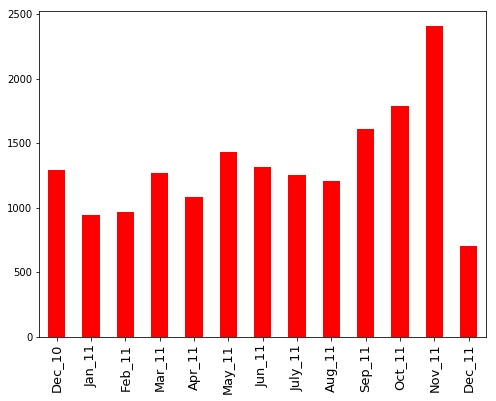

In [25]:
ax=sales_ff.groupby('transaction timestamp')['year_month'].unique().value_counts().sort_index().plot('bar',color='red',figsize=(8,6))
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='vertical', fontsize=13)
plt.show()

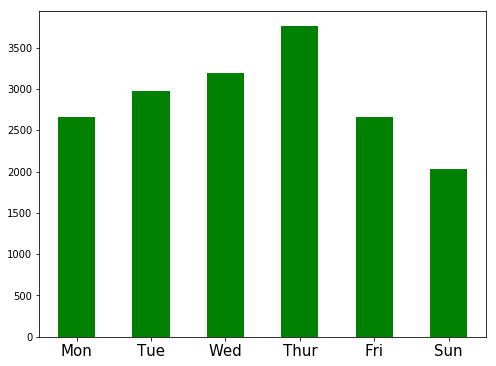

In [26]:
ax=sales_ff.groupby('transaction timestamp')['day'].unique().value_counts().sort_index().plot('bar',color='green',figsize=(8,6))
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

#### Thursday seems to be the day on which most products are sold.

#### In contrast friday, and sunday have very low transactions

#### On saturday there are no transactions at all


### Number of Orders By hour

Text(0.5,0,'Hour')

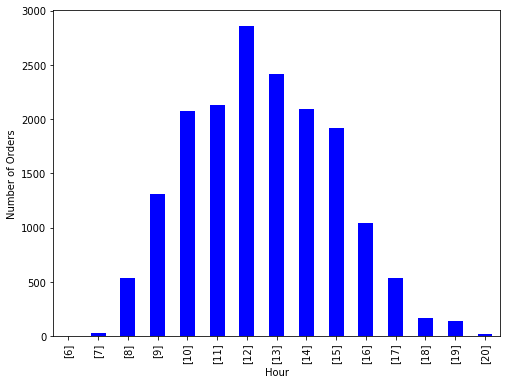

In [27]:
ax=sales_ff.groupby('transaction timestamp')['hour'].unique().value_counts().sort_index().plot('bar',color='blue',figsize=(8,6))
ax.set_ylabel('Number of Orders')
ax.set_xlabel('Hour')


### We can visualise that the majorly orders are in afternoon and maximum orders are done at 12 pm.

### Visualising Unit Price

In [28]:
sales_ff['unit price'].describe()

count    392692.000000
mean          3.125914
std          22.241836
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: unit price, dtype: float64

In [29]:
p=sales_ff[sales_ff['unit price']<1]
p

,transaction id,product id,year_month,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount
29,536370,21724,201012,PANDA AND BUNNIES STICKER SHEET,12,2,8,2010,12,2010-12-01 08:45:00,0.85,12583.0,France,10.20
30,536370,21883,201012,STARS GIFT TAPE,12,2,8,2010,24,2010-12-01 08:45:00,0.65,12583.0,France,15.60
31,536370,10002,201012,INFLATABLE POLITICAL GLOBE,12,2,8,2010,48,2010-12-01 08:45:00,0.85,12583.0,France,40.80
38,536370,22661,201012,CHARLOTTE BAG DOLLY GIRL DESIGN,12,2,8,2010,20,2010-12-01 08:45:00,0.85,12583.0,France,17.00
42,536370,22540,201012,MINI JIGSAW CIRCUS PARADE,12,2,8,2010,24,2010-12-01 08:45:00,0.42,12583.0,France,10.08
43,536370,22544,201012,MINI JIGSAW SPACEBOY,12,2,8,2010,24,2010-12-01 08:45:00,0.42,12583.0,France,10.08
44,536370,22492,201012,MINI PAINT SET VINTAGE,12,2,8,2010,36,2010-12-01 08:45:00,0.65,12583.0,France,23.40
89,536378,20723,201012,STRAWBERRY CHARLOTTE BAG,12,2,9,2010,10,2010-12-01 09:37:00,0.85,14688.0,United Kingdom,8.50
92,536378,21094,201012,SET/6 RED SPOTTY PAPER PLATES,12,2,9,2010,12,2010-12-01 09:37:00,0.85,14688.0,United Kingdom,10.20
96,536378,21212,201012,PACK OF 72 RETROSPOT CAKE CASES,12,2,9,2010,120,2010-12-01 09:37:00,0.42,14688.0,United Kingdom,50.40


### As we can see there are many products which have unit price less then 1. They include bank transaction charges, small decoration products like gift tapes etc.

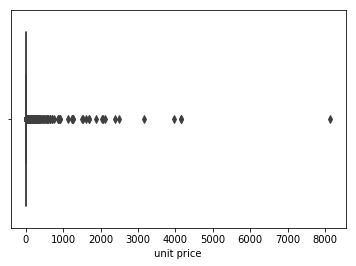

In [30]:
sns.boxplot(sales_ff['unit price'])

### MOST SOLD PRODUCTS

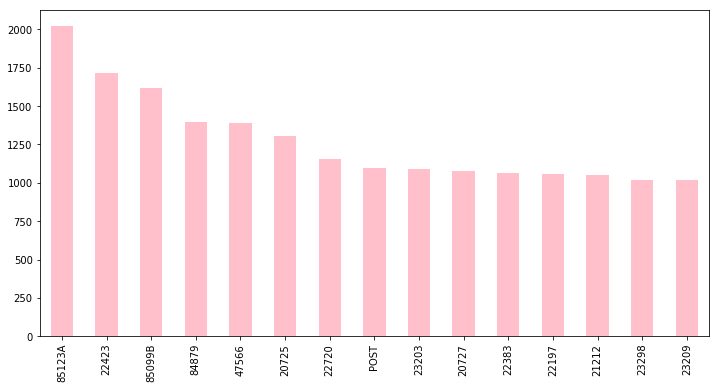

In [31]:
sales_ff['product id'].value_counts().head(15).plot('bar',color='pink',figsize=(12,6))

## MOST SOLD PRODUCTS QUANTITY WISE

In [32]:
p11=sales_ff.groupby(['product id'])['quantity sold'].sum()
p11

product id
10002             823
10080             291
10120             192
10125            1225
10133            2373
10135            1936
11001            1252
15030             143
15034            6419
15036           21876
15039            1558
16008            2892
16010              30
16011            1749
16012            1220
16014           13328
16015             662
16016            1273
16033             840
16043              98
16045            8900
16046              64
16048            1436
16049             504
16052             467
16054            1166
16216            3316
16218            3760
16219            2915
16225             760
                ...  
90214A             63
90214B             13
90214C             52
90214D             39
90214E             41
90214F             13
90214G             34
90214H             22
90214I             25
90214J             23
90214K             47
90214L             51
90214M             27
90214N             18

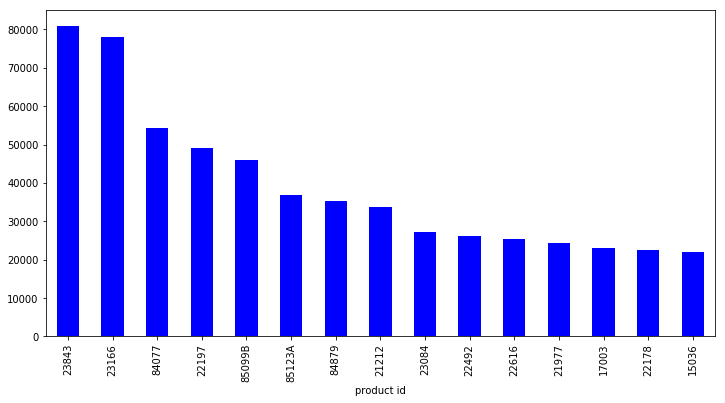

In [33]:
p11.sort_values(ascending=False).head(15).plot('bar',color='blue',figsize=(12,6))

## Visualising for each Country 

### Number of orders

In [34]:
order_c=sales_ff.groupby('transaction country')['transaction timestamp'].count().sort_values(ascending=False)
order_c.head(10)

transaction country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1453
Australia           1181
Name: transaction timestamp, dtype: int64

### It can be seen  that around 90% of the orders exist in United Kingdom only followed by Germany and France. 

Text(0.5,0,'Number Of Orders')

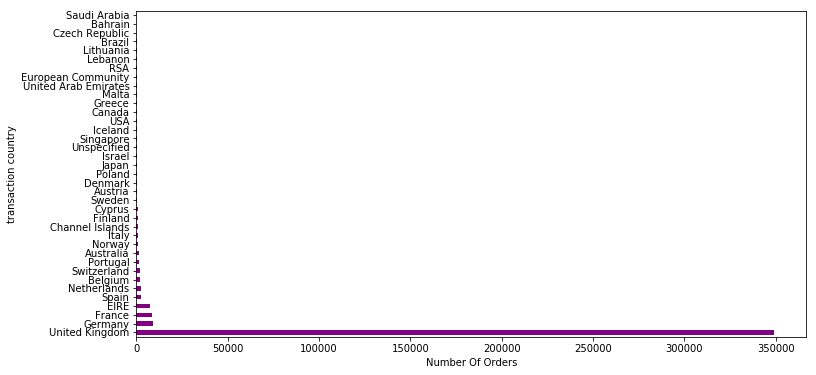

In [35]:
ax=order_c.plot('barh',figsize=(12,6),color='purple')
ax.set_xlabel('Number Of Orders')

### It is clearly visible United Kingdom has fairly large amount of orders then any country.

In [36]:
order_c1=sales_ff.groupby('transaction country')['transaction timestamp'].nunique().sort_values(ascending=False)
order_c1.head(10)

transaction country
United Kingdom    15612
Germany             452
France              390
EIRE                259
Belgium              98
Netherlands          94
Spain                90
Portugal             57
Australia            55
Switzerland          51
Name: transaction timestamp, dtype: int64

Text(0.5,0,'Number Of Unique Orders')

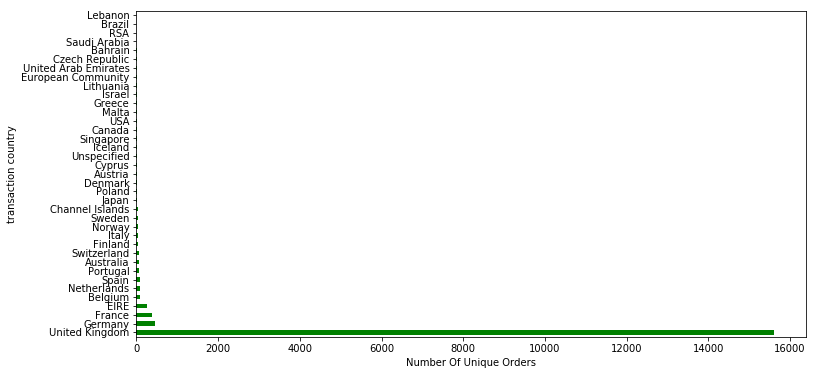

In [37]:
ax=order_c1.plot('barh',figsize=(12,6),color='green')
ax.set_xlabel('Number Of Unique Orders')

### It is clearly visible United Kingdom has maximum unique orders.

### Amount Spent by each country 

In [38]:
amount_c=sales_ff.groupby('transaction country')['Amount'].sum().sort_values(ascending=False)
amount_c.head(10)

transaction country
United Kingdom    7.285025e+06
Netherlands       2.854463e+05
EIRE              2.652625e+05
Germany           2.286784e+05
France            2.089343e+05
Australia         1.384538e+05
Spain             6.155856e+04
Switzerland       5.644395e+04
Belgium           4.119634e+04
Sweden            3.836783e+04
Name: Amount, dtype: float64

Text(0.5,0,'Number Of Orders')

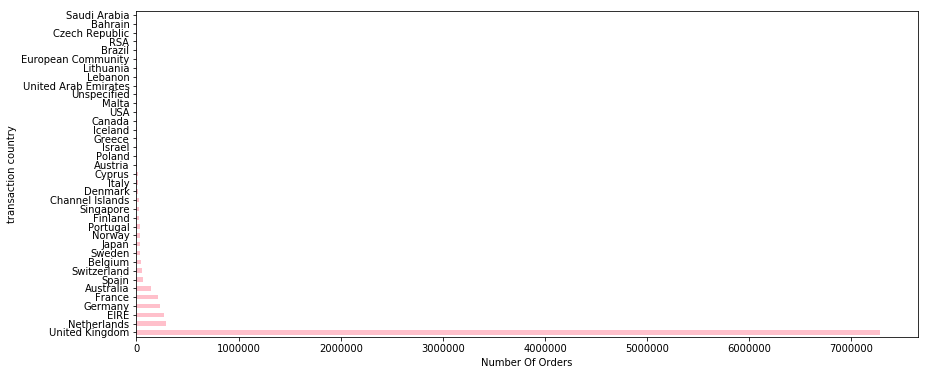

In [39]:
ax=amount_c.plot('barh',figsize=(14,6),color='pink')
ax.set_xlabel('Number Of Orders')

### Amount spent by UK is very large then all other countries. It is followed by Netherlands. 

### We have categorised region wise for five countries and grouped them by transaction id for each product description.

In [40]:
 

basket_France = (sales_ff[sales_ff['transaction country'] =="France"] 
          .groupby(['transaction id', 'product description'])['quantity sold'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('transaction id')) 

basket_Sweden = (sales_ff[sales_ff['transaction country'] =="Sweden"] 
          .groupby(['transaction id', 'product description'])['quantity sold'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('transaction id')) 

basket_e = (sales_ff[sales_ff['transaction country'] =="EIRE"] 
          .groupby(['transaction id', 'product description'])['quantity sold'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('transaction id')) 

basket_Pot = (sales_ff[sales_ff['transaction country'] =="Portugal"] 
          .groupby(['transaction id', 'product description'])['quantity sold'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('transaction id')) 

basket_Net = (sales_ff[sales_ff['transaction country'] =="Netherlands"] 
          .groupby(['transaction id', 'product description'])['quantity sold'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('transaction id')) 


In [41]:
basket_France.head()

product description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
transaction id,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1
  
# Encoding the datasets 
basket_encoded = basket_France.applymap(hot_encode) 
basket_France = basket_encoded 
  

basket_encoded = basket_Net.applymap(hot_encode) 
basket_Net = basket_encoded 
  
basket_encoded = basket_Pot.applymap(hot_encode) 
basket_Pot = basket_encoded 

basket_encoded = basket_e.applymap(hot_encode) 
basket_e = basket_encoded 

basket_encoded = basket_Sweden.applymap(hot_encode) 
basket_Sweden = basket_encoded 


### Basically We plan to showcase the products which are frequently bought together by use of Apriori Algorithm country wise. We have chosen five countries-

##### 1 .France
##### 2. Netherlands
##### 3. Portugal
##### 4. EIRE
##### 5. Portugal

In [43]:
# Building the model 
frq_items = apriori(basket_France, min_support = 0.05, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = (rules.sort_values(['confidence', 'lift'], ascending =[False, False])) 
print(rules.head()) 

                                           antecedents  \
44                        (JUMBO BAG WOODLAND ANIMALS)   
257  (RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...   
268  (RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...   
300  (SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...   
299  (SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...   

                         consequents  antecedent support  consequent support  \
44                         (POSTAGE)            0.077121            0.771208   
257                        (POSTAGE)            0.051414            0.771208   
268                        (POSTAGE)            0.053985            0.771208   
300  (SET/6 RED SPOTTY PAPER PLATES)            0.102828            0.128535   
299    (SET/6 RED SPOTTY PAPER CUPS)            0.102828            0.138817   

      support  confidence      lift  leverage  conviction  
44   0.077121       1.000  1.296667  0.017645         inf  
257  0.051414       1.000  1.296667  0.011763     

### From the above output, it can be seen that paper cups and paper and plates are bought together in France. This is because the French have a culture of having a get-together with their friends and family atleast once a week.

In [44]:
frq_items = apriori(basket_Net, min_support = 0.05, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = (rules.sort_values(['confidence', 'lift'], ascending =[False, False])) 
print(rules.head()) 

                                            antecedents  \
650                (FOLDING BUTTERFLY MIRROR HOT PINK )   
651                    (FOLDING BUTTERFLY MIRROR RED  )   
1352  (CARD DOLLY GIRL , FOOD CONTAINER SET 3 LOVE H...   
1353                           (10 COLOUR SPACEBOY PEN)   
1381  (STRAWBERRY LUNCH BOX WITH CUTLERY, CARD DOLLY...   

                                            consequents  antecedent support  \
650                    (FOLDING BUTTERFLY MIRROR RED  )            0.053191   
651                (FOLDING BUTTERFLY MIRROR HOT PINK )            0.053191   
1352                           (10 COLOUR SPACEBOY PEN)            0.053191   
1353  (CARD DOLLY GIRL , FOOD CONTAINER SET 3 LOVE H...            0.053191   
1381                           (10 COLOUR SPACEBOY PEN)            0.053191   

      consequent support   support  confidence  lift  leverage  conviction  
650             0.053191  0.053191         1.0  18.8  0.050362         inf  
651             

### On analyzing the association rules for Netherland transactions, folding butterfly of two different colors are combined.

In [45]:
frq_items = apriori(basket_Pot, min_support = 0.05, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

                              antecedents  \
1146  (SET 12 COLOUR PENCILS DOLLY GIRL )   
1147    (SET 12 COLOUR PENCILS SPACEBOY )   
1148  (SET OF 4 KNICK KNACK TINS LONDON )   
1149  (SET 12 COLOUR PENCILS DOLLY GIRL )   
1150  (SET OF 4 KNICK KNACK TINS POPPIES)   

                              consequents  antecedent support  \
1146    (SET 12 COLOUR PENCILS SPACEBOY )            0.052632   
1147  (SET 12 COLOUR PENCILS DOLLY GIRL )            0.052632   
1148  (SET 12 COLOUR PENCILS DOLLY GIRL )            0.052632   
1149  (SET OF 4 KNICK KNACK TINS LONDON )            0.052632   
1150  (SET 12 COLOUR PENCILS DOLLY GIRL )            0.052632   

      consequent support   support  confidence  lift  leverage  conviction  
1146            0.052632  0.052632         1.0  19.0  0.049861         inf  
1147            0.052632  0.052632         1.0  19.0  0.049861         inf  
1148            0.052632  0.052632         1.0  19.0  0.049861         inf  
1149            0.052632  0.05

### On analyzing the association rules for Portuguese transactions, it is observed that Tiffin sets (Knick Knack Tins) and colour pencils are clubbed as these two products typically belong to a primary school going kid which is so relevant.

In [46]:
frq_items = apriori(basket_e, min_support = 0.05, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

                                            antecedents  \
1023  (REGENCY TEA PLATE ROSES , GREEN REGENCY TEACU...   
1055  (REGENCY TEA PLATE PINK, PINK REGENCY TEACUP A...   
1084  (REGENCY TEA PLATE ROSES , PINK REGENCY TEACUP...   
342   (REGENCY TEA PLATE PINK, REGENCY CAKESTAND 3 T...   
604   (REGENCY TEA PLATE ROSES , GREEN REGENCY TEACU...   

                                            consequents  antecedent support  \
1023  (REGENCY TEA PLATE GREEN , ROSES REGENCY TEACU...            0.050000   
1055  (REGENCY TEA PLATE GREEN , ROSES REGENCY TEACU...            0.050000   
1084  (REGENCY TEA PLATE GREEN , ROSES REGENCY TEACU...            0.050000   
342                          (REGENCY TEA PLATE GREEN )            0.061538   
604                          (REGENCY TEA PLATE GREEN )            0.050000   

      consequent support   support  confidence       lift  leverage  \
1023            0.061538  0.050000         1.0  16.250000  0.046923   
1055            0.061538  0.

### Clearly We can see that green regency teacup and saucer is paired with roses regency teacup and saucer which makes sense that two different varieties of same product are combined together.

In [47]:
frq_items = apriori(basket_Sweden, min_support = 0.05, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

                         antecedents                        consequents  \
0      (PACK OF 72 SKULL CAKE CASES)      (12 PENCILS SMALL TUBE SKULL)   
1      (12 PENCILS SMALL TUBE SKULL)      (PACK OF 72 SKULL CAKE CASES)   
4            (36 DOILIES DOLLY GIRL)    (ASSORTED BOTTLE TOP  MAGNETS )   
5    (ASSORTED BOTTLE TOP  MAGNETS )            (36 DOILIES DOLLY GIRL)   
180  (CHILDRENS CUTLERY DOLLY GIRL )  (CHILDRENS CUTLERY CIRCUS PARADE)   

     antecedent support  consequent support   support  confidence  lift  \
0              0.055556            0.055556  0.055556         1.0  18.0   
1              0.055556            0.055556  0.055556         1.0  18.0   
4              0.055556            0.055556  0.055556         1.0  18.0   
5              0.055556            0.055556  0.055556         1.0  18.0   
180            0.055556            0.055556  0.055556         1.0  18.0   

     leverage  conviction  
0    0.052469         inf  
1    0.052469         inf  
4    0.052469 

### In Sweden we can see that  boys’ and girls’ cutlery are paired together. This makes practical sense because when a parent goes shopping for cutlery for his/her children, he/she would want the product to be a little customized according to the kid’s wishes


###  We gathered information country wise  for some countries  that which two items are frequently bought together. Understanding these buying patterns can help to increase sales in several ways-

#### 1.If someone buys one item we can recommend other item also as it is highly likely that the customer may buy second item also.

#### 2.Promotional discounts could be applied by clubbing both something like combo offer.

#### 3.Advertisements of one product could be targeted at buyers who purchase another product frequently.


## Grouping by customers

In [48]:
Order=sales_ff.groupby(by=['customer id'])['transaction timestamp'].count()
Order.head(20)

customer id
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
12352.0     85
12353.0      4
12354.0     58
12355.0     13
12356.0     59
12357.0    131
12358.0     19
12359.0    245
12360.0    129
12361.0     10
12362.0    266
12363.0     23
12364.0     85
12365.0     22
12367.0     11
Name: transaction timestamp, dtype: int64

customer id
17841.0    7676
14911.0    5670
14096.0    5111
12748.0    4412
14606.0    2677
15311.0    2366
14646.0    2076
13089.0    1814
13263.0    1667
14298.0    1637
Name: transaction timestamp, dtype: int64


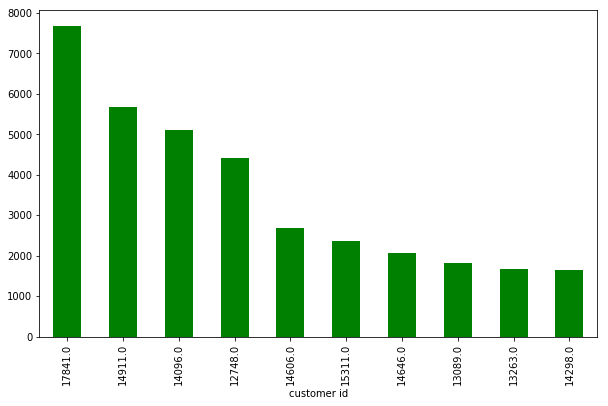

In [49]:
Order=Order.sort_values(ascending=False).head(10)
print(Order)
Order.plot('bar',color='green',figsize=(10,6))

### Customer with Id 17841 makes most transactions.

customer id
14646.0    280206.02
18102.0    259657.30
17450.0    194390.79
16446.0    168472.50
14911.0    143711.17
12415.0    124914.53
14156.0    117210.08
17511.0     91062.38
16029.0     80850.84
12346.0     77183.60
Name: Amount, dtype: float64


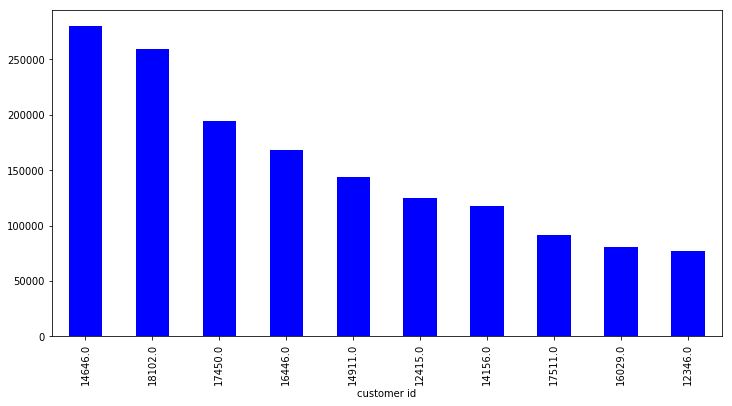

In [50]:
Amount=sales_ff.groupby(by=['customer id'])['Amount'].sum().sort_values(ascending=False).head(10)
print(Amount)
Amount.plot('bar',color='blue',figsize=(12,6))

### Customer with ID 14646 spends most amount of money.

### As we have seen UK is most important for our analysis.So we have applied RFM analysis on UK to segment customers in groups

## Recency (R)

### Recency is the most important predictor of who is more likely to respond to an offer. Customers who have purchased recently are more likely to purchase again when compared to those who did not purchase recently.

### To tag the customers on the basis of recency flag, we will first filter the customers of United Kingdom and take distinct dates of their purchase.

In [51]:
Cust_uk=sales_ff[sales_ff['transaction country']=='United Kingdom']
Cust_uk.head()

,transaction id,product id,year_month,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount
0,536365,85123A,201012,WHITE HANGING HEART T-LIGHT HOLDER,12,2,8,2010,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,201012,WHITE METAL LANTERN,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,201012,CREAM CUPID HEARTS COAT HANGER,12,2,8,2010,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,201012,KNITTED UNION FLAG HOT WATER BOTTLE,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,201012,RED WOOLLY HOTTIE WHITE HEART.,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [52]:
Cust_uk=Cust_uk[['customer id','year_month']].drop_duplicates()

In [53]:
Cust_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11790 entries, 0 to 541890
Data columns (total 2 columns):
customer id    11790 non-null float64
year_month     11790 non-null int64
dtypes: float64(1), int64(1)
memory usage: 276.3 KB


In [54]:
def cust(c):
    if c['year_month']>201110:
        value=5
    elif c['year_month']<=201110 and c['year_month']>201108:
        value=4
    elif c['year_month']<=201108 and c['year_month']>201106: 
        value=3
    elif c['year_month']<=201106 and c['year_month']>201104:
        value=2
    else:
        value=1
    return value        

In [55]:
Cust_uk['Recency']=Cust_uk.apply(cust,axis=1)

In [56]:
Cust_uk = Cust_uk.groupby('customer id',as_index=False)['Recency'].max()

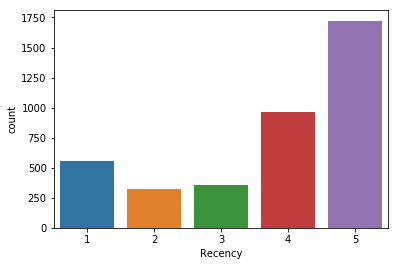

In [57]:
sns.countplot(Cust_uk['Recency'])

### Almost half users have made recent transactions in last two months while we can see many customers have not visited the store in last 4–8 months.We have to specially target this customers to reagain our pool of customers.

In [58]:
Cust_freq=sales_ff[['transaction country','transaction id','customer id']].drop_duplicates()

## Frequency (F)

### The second most important factor is how frequently these customers purchase. The higher the frequency, the higher is the chances of these responding to the offers.

### To tag the customers on the basis of frequency flag, we will take country wise count of distinct invoice number for each customer and then filter out the customers of United Kingdom.

In [59]:
Cust_freq_count=Cust_freq.groupby(['transaction country','customer id'])['transaction id'].aggregate('count').reset_index().sort_values('transaction id', ascending=False)

In [60]:
Cust_freq_count.head()

,transaction country,customer id,transaction id
424,United Kingdom,12748.0,209
81,EIRE,14911.0,201
4015,United Kingdom,17841.0,124
613,United Kingdom,13089.0,97
1689,United Kingdom,14606.0,93


In [61]:
Cust_freq_count_UK=Cust_freq_count[Cust_freq_count['transaction country']=='United Kingdom']
Cust_freq_count_UK.head()

,transaction country,customer id,transaction id
424,United Kingdom,12748.0,209
4015,United Kingdom,17841.0,124
613,United Kingdom,13089.0,97
1689,United Kingdom,14606.0,93
2193,United Kingdom,15311.0,91


In [62]:
Cust_freq_count_UK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3920 entries, 424 to 2173
Data columns (total 3 columns):
transaction country    3920 non-null object
customer id            3920 non-null float64
transaction id         3920 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 122.5+ KB


In [63]:
unique_invoice=Cust_freq_count_UK[['transaction id']].drop_duplicates()

In [64]:
unique_invoice['Freqency_Band'] = pd.qcut(unique_invoice['transaction id'], 5)

In [65]:
unique_invoice=unique_invoice[['Freqency_Band']].drop_duplicates()
unique_invoice

,Freqency_Band
424,"(50.8, 209.0]"
1042,"(34.6, 50.8]"
3694,"(23.4, 34.6]"
2416,"(12.2, 23.4]"
946,"(0.999, 12.2]"


In [66]:
def f(row):
    
    if row['transaction id'] <= 12.2:
        val = 1
    elif row['transaction id'] > 12.2 and row['transaction id'] <= 23.4:
        val = 2
    elif row['transaction id'] > 23.4 and row['transaction id'] <= 34.6:
        val = 3
    elif row['transaction id'] > 34.6 and row['transaction id'] <= 50.8:
        val = 4
    else:
        val = 5
    return val  

In [67]:
Cust_freq_count_UK['Freq_Flag'] = Cust_freq_count_UK.apply(f, axis=1)

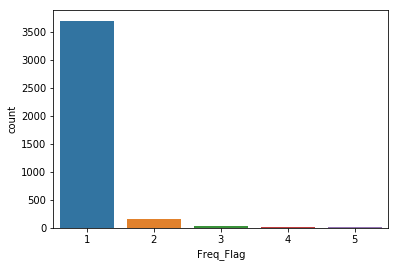

In [68]:
sns.countplot(Cust_freq_count_UK['Freq_Flag'])

### It can be seen that maximum customers are visiting the store less than 12 times a year 

## Monetary Value (M)

### The third factor is the amount of money these customers have spent on purchases. Customers who have spent higher contribute more value to the business as compared to those who have spent less.

### To tag the customers on the basis of monetary flag, we will take country wise sum of Total price for each customer and then filter out the customers of United Kingdom.

In [69]:
Cust_monetary = sales_ff.groupby(['transaction country','customer id'])['Amount'].aggregate('sum').reset_index().sort_values('Amount', ascending=False)

In [70]:
Cust_monetary.head()

,transaction country,customer id,Amount
318,Netherlands,14646.0,280206.02
4205,United Kingdom,18102.0,259657.30
3736,United Kingdom,17450.0,194390.79
3020,United Kingdom,16446.0,168472.50
81,EIRE,14911.0,143711.17


In [71]:
Cust_monetary_UK=Cust_monetary[Cust_monetary['transaction country']=='United Kingdom']
Cust_monetary_UK.head()

,transaction country,customer id,Amount
4205,United Kingdom,18102.0,259657.30
3736,United Kingdom,17450.0,194390.79
3020,United Kingdom,16446.0,168472.50
3778,United Kingdom,17511.0,91062.38
2716,United Kingdom,16029.0,80850.84


In [72]:
Cust_monetary_UK.describe()

,customer id,Amount
count,3920.000000,3920.000000
mean,15562.059694,1858.424654
std,1576.594671,7478.631256
min,12346.000000,3.750000
25%,14208.750000,298.185000
50%,15569.500000,644.975000
75%,16913.250000,1571.285000
max,18287.000000,259657.300000


In [73]:
unique_price=Cust_monetary_UK[['Amount']].drop_duplicates()

In [74]:
unique_price=unique_price[unique_price['Amount'] > 0]
unique_price['monetary_Band'] = pd.qcut(unique_price['Amount'], 5)

In [75]:
unique_price=unique_price[['monetary_Band']].drop_duplicates()
unique_price

,monetary_Band
4205,"(1972.286, 259657.3]"
2938,"(910.756, 1972.286]"
1039,"(476.056, 910.756]"
2333,"(245.836, 476.056]"
3974,"(3.749, 245.836]"


In [76]:
def f(row):
    
    if row['Amount'] <= 245.98:
        val = 1
    elif row['Amount'] > 245.98 and row['Amount'] <= 476.252:
        val = 2
    elif row['Amount'] > 476.252 and row['Amount'] <= 911.396:
        val = 3
    elif row['Amount'] > 911.396 and row['Amount'] <= 1972.182:
        val = 4
    else:
        val = 5
    return val

In [77]:
Cust_monetary_UK['Monetary_Flag'] = Cust_monetary_UK.apply(f, axis=1)

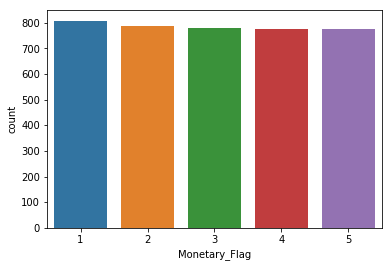

In [78]:
sns.countplot(Cust_monetary_UK['Monetary_Flag'])

### There is an almost equal distribution of customers as far as monetary value is concerned.

In [79]:
Cust_UK_All=pd.merge(Cust_uk,Cust_freq_count_UK[['customer id','Freq_Flag']],on=['customer id'],how='left')
Cust_UK_All=pd.merge(Cust_UK_All,Cust_monetary_UK[['customer id','Monetary_Flag']],on=['customer id'],how='left')
Cust_UK_All.head(10)

,customer id,Recency,Freq_Flag,Monetary_Flag
0,12346.0,1,1,5
1,12747.0,5,1,5
2,12748.0,5,5,5
3,12749.0,5,1,5
4,12820.0,5,1,4
5,12821.0,2,1,1
6,12822.0,4,1,4
7,12823.0,4,1,4
8,12824.0,4,1,2
9,12826.0,5,1,4


In [80]:
Cust_UK_All['RFMScore'] = Cust_UK_All.Recency.map(str) + Cust_UK_All.Freq_Flag.map(str) + Cust_UK_All.Monetary_Flag.map(str)

In [81]:
Cust_UK_All.head()

,customer id,Recency,Freq_Flag,Monetary_Flag,RFMScore
0,12346.0,1,1,5,115
1,12747.0,5,1,5,515
2,12748.0,5,5,5,555
3,12749.0,5,1,5,515
4,12820.0,5,1,4,514


In [82]:
print("Best Customers:",len(Cust_UK_All[Cust_UK_All['RFMScore']=='555']))
print('Loyal Customers:',len(Cust_UK_All[Cust_UK_All['Freq_Flag']==5]))
print("Big Spenders:",len(Cust_UK_All[Cust_UK_All['Monetary_Flag']==5]))
print('Almost Lost:', len(Cust_UK_All[Cust_UK_All['RFMScore']=='521']))
print('Lost Customers:',len(Cust_UK_All[Cust_UK_All['RFMScore']=='311']))
print('Lost Cheap Customers:',len(Cust_UK_All[Cust_UK_All['RFMScore']=='111']))

Best Customers: 12
Loyal Customers: 12
Big Spenders: 775
Almost Lost: 0
Lost Customers: 86
Lost Cheap Customers: 255



### Based on business requirements, various cut-offs are imposed on each of the three parameters. After applying the cut-offs, customers can be classified mainly in six segments:

#### 1. Best Customers 

#### 2. Loyal Customers 

#### 3. Big Spenders 

#### 4.Almost Lost

#### 5. Lost Customers 

#### 6. Lost Cheap Customers 




## Building a customer table for all countries

In [83]:
sales_ff.head()

,transaction id,product id,year_month,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount
0,536365,85123A,201012,WHITE HANGING HEART T-LIGHT HOLDER,12,2,8,2010,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,201012,WHITE METAL LANTERN,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,201012,CREAM CUPID HEARTS COAT HANGER,12,2,8,2010,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,201012,KNITTED UNION FLAG HOT WATER BOTTLE,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,201012,RED WOOLLY HOTTIE WHITE HEART.,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [84]:
monetary_df=sales_ff.groupby('customer id',as_index=False)['Amount'].sum()
monetary_df.columns = ['customer id','Monetary']

In [85]:
monetary_df.head()


,customer id,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [86]:
#when was their last order and how long ago was that from the last date in file 
last_order = sales_ff.groupby(by='customer id', as_index=False)['transaction timestamp'].max()
last_order.columns = ['customer id', 'last_purchase']
last_order['Now'] = pd.to_datetime((sales_ff['transaction timestamp']).max())
last_order['Recency'] =  (last_order.Now-last_order.last_purchase).astype('timedelta64[D]')
last_order.drop('Now', axis=1, inplace=True)
last_order.head()

,customer id,last_purchase,Recency
0,12346.0,2011-01-18 10:01:00,325.0
1,12347.0,2011-12-07 15:52:00,1.0
2,12348.0,2011-09-25 13:13:00,74.0
3,12349.0,2011-11-21 09:51:00,18.0
4,12350.0,2011-02-02 16:01:00,309.0


In [87]:
last_order.drop(columns=['last_purchase'],inplace=True)

In [88]:
frequency_df = sales_ff.copy()
frequency_df.drop_duplicates(subset=['customer id','transaction id'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('customer id',as_index=False)['transaction id'].count()
frequency_df.columns = ['customer id','Frequency']
frequency_df.head()

,customer id,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [89]:
rf = last_order.merge(frequency_df,left_on='customer id',right_on='customer id')

#combibe rf frame with monetary values..

rfm = rf.merge(monetary_df,left_on='customer id',right_on='customer id')

rfm.set_index('customer id',inplace=True)

In [90]:
rfm.head()

,Recency,Frequency,Monetary
customer id,,,
12346.0,325.0,1,77183.60
12347.0,1.0,7,4310.00
12348.0,74.0,4,1797.24
12349.0,18.0,1,1757.55
12350.0,309.0,1,334.40


In [91]:
rfm_segmentation = rfm.copy()

### Clustering customers on basis of RFM using K-means

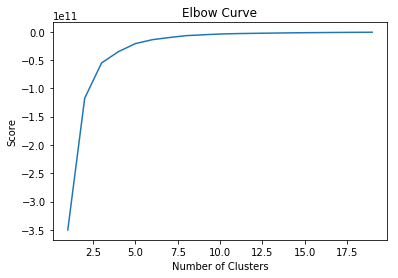

In [92]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [93]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

In [94]:
rfm_segmentation['cluster'] = kmeans.labels_

In [95]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster
customer id,,,,
12346.0,325.0,1,77183.60,1
12347.0,1.0,7,4310.00,0
12348.0,74.0,4,1797.24,0
12349.0,18.0,1,1757.55,0
12350.0,309.0,1,334.40,0


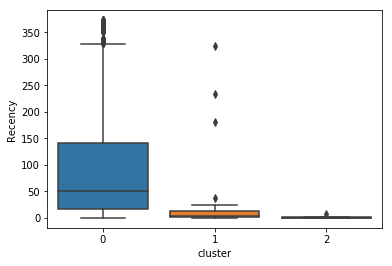

In [96]:
sns.boxplot(rfm_segmentation.cluster,rfm_segmentation.Recency)


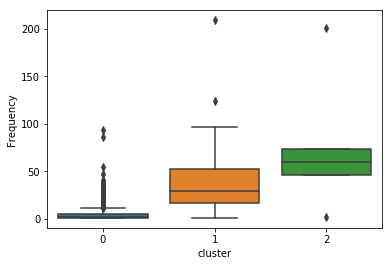

In [97]:
sns.boxplot(rfm_segmentation.cluster,rfm_segmentation.Frequency)


### Cluster 0 have low frequency rate which is bad.

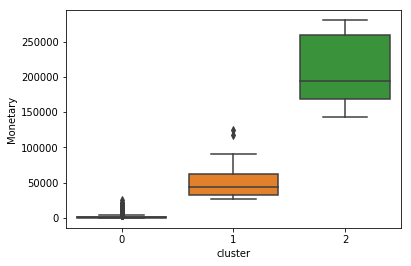

In [98]:
sns.boxplot(rfm_segmentation.cluster,rfm_segmentation.Monetary)


### cluster 0 have low Monetary rate which is bad.

## Based on customer Segmentation we found out cluster 1 are Platinum customers ,Cluster 2 are Gold Customers and Cluster 3 are Silver Customers

In [99]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

#lower the recency, good for store..
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

#higher value of frequency and monetary lead to a good consumer. here higher value = 1 in reverse way.

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [100]:
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile


,Recency,Frequency,Monetary
0.25,17.0,1.0,306.4825
0.50,50.0,2.0,668.5700
0.75,141.0,5.0,1660.5975


In [101]:
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantile))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [102]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) + rfm_segmentation.F_Quartile.map(str) + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
customer id,,,,,,,,
12346.0,325.0,1,77183.60,1,4,4,1,441
12347.0,1.0,7,4310.00,0,1,1,1,111
12348.0,74.0,4,1797.24,0,3,2,1,321
12349.0,18.0,1,1757.55,0,2,4,1,241
12350.0,309.0,1,334.40,0,4,4,3,443


In [103]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  461
Loyal Customers:  872
Big Spenders:  1085
Almost Lost:  36
Lost Customers:  209
Lost Cheap Customers:  440


### Now,we have a count of our different segment customers which we have to target separately for increasing sales.

In [104]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])


,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
customer id,,,,,,,,
14646.0,1.0,73,280206.02,2,1,1,1,111
18102.0,0.0,60,259657.30,2,1,1,1,111
17450.0,7.0,46,194390.79,2,1,1,1,111
14911.0,0.0,201,143711.17,2,1,1,1,111
14156.0,9.0,55,117210.08,1,1,1,1,111
17511.0,2.0,31,91062.38,1,1,1,1,111
16684.0,3.0,28,66653.56,1,1,1,1,111
14096.0,3.0,17,65164.79,1,1,1,1,111
13694.0,3.0,50,65039.62,1,1,1,1,111


In [105]:
rfm_segmentation['Total_score'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] + rfm_segmentation['M_Quartile']

In [106]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
customer id,,,,,,,,,
12346.0,325.0,1,77183.60,1,4,4,1,441,9
12347.0,1.0,7,4310.00,0,1,1,1,111,3
12348.0,74.0,4,1797.24,0,3,2,1,321,6
12349.0,18.0,1,1757.55,0,2,4,1,241,7
12350.0,309.0,1,334.40,0,4,4,3,443,11


###  Calculating mean and Count of Customers of different segments

In [107]:
rfm_segmentation.groupby('Total_score').agg({'Recency': 'mean','Frequency': 'mean',
                             'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
               mean      mean     mean count
Total_score                                 
3               6.3      16.2   9455.7   461
4              19.5       8.1   4164.8   335
5              28.3       5.1   2411.0   397
6              41.8       3.9   1455.1   423
7              59.2       3.0   1183.7   424
8              75.2       2.3    780.4   420
9              90.3       1.7    711.5   474
10            112.0       1.4    382.4   469
11            180.9       1.1    286.8   495
12            266.4       1.0    163.5   440

In [108]:
rfm_segmentation.groupby('Total_score')['Monetary'].mean()

Total_score
3     9455.742364
4     4164.810149
5     2411.014332
6     1455.123241
7     1183.690825
8      780.426124
9      711.486730
10     382.439362
11     286.847434
12     163.518886
Name: Monetary, dtype: float64

### Based on Monetary we see Total_score 3,4,5 have highest value which is good for model. because it could have combination of values such as 111, 121, 122 etc.

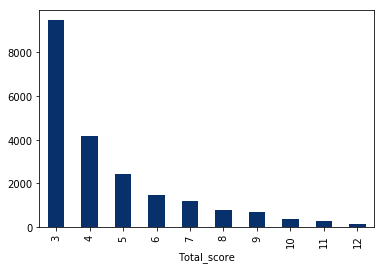

In [109]:
rfm_segmentation.groupby('Total_score')['Monetary'].mean().plot(kind='bar', colormap='Blues_r')


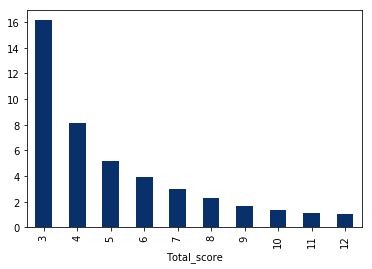

In [110]:
rfm_segmentation.groupby('Total_score')['Frequency'].mean().plot(kind='bar', colormap='Blues_r')

### Based on Frequency also we see Total_score 3,4,5 have highest value which is good for model. because it could have combination of values such as 111, 121, 122 etc

In [111]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
customer id,,,,,,,,,
12346.0,325.0,1,77183.60,1,4,4,1,441,9
12347.0,1.0,7,4310.00,0,1,1,1,111,3
12348.0,74.0,4,1797.24,0,3,2,1,321,6
12349.0,18.0,1,1757.55,0,2,4,1,241,7
12350.0,309.0,1,334.40,0,4,4,3,443,11


## Clustering of Customers based on Number of items,Total Amount and Number of orders made

In [112]:
# No of orders made
n_orders=sales_ff.groupby('customer id',as_index=False)['transaction timestamp'].count()
n_orders.columns=['customer id','N_Orders']
n_orders.describe()

,customer id,N_Orders
count,4338.000000,4338.000000
mean,15300.408022,90.523744
std,1721.808492,225.506968
min,12346.000000,1.000000
25%,13813.250000,17.000000
50%,15299.500000,41.000000
75%,16778.750000,98.000000
max,18287.000000,7676.000000


In [113]:
# Money Spent
total_spend = sales_ff.groupby(by='customer id',as_index=False)['Amount'].sum()
total_spend.columns = ['customer id', 'total_spent']
total_spend.describe()

,customer id,total_spent
count,4338.000000,4338.000000
mean,15300.408022,2048.688081
std,1721.808492,8985.230220
min,12346.000000,3.750000
25%,13813.250000,306.482500
50%,15299.500000,668.570000
75%,16778.750000,1660.597500
max,18287.000000,280206.020000


In [114]:
#how many items they bought
total_items = sales_ff.groupby(by='customer id',as_index=False)['quantity sold'].sum()
total_items.columns = ['customer id', 'NumberItems']
total_items.describe()

,customer id,NumberItems
count,4338.000000,4338.000000
mean,15300.408022,1187.644537
std,1721.808492,5043.619654
min,12346.000000,1.000000
25%,13813.250000,159.000000
50%,15299.500000,378.000000
75%,16778.750000,989.750000
max,18287.000000,196915.000000


In [115]:
cust_table=pd.merge(n_orders,total_spend,on=['customer id'],how='left')

In [116]:
cust_table=pd.merge(cust_table,total_items,on=['customer id'],how='left')

In [117]:
cust_table.head()

,customer id,N_Orders,total_spent,NumberItems
0,12346.0,1,77183.60,74215
1,12347.0,182,4310.00,2458
2,12348.0,31,1797.24,2341
3,12349.0,73,1757.55,631
4,12350.0,17,334.40,197


In [118]:
X = cust_table.iloc[:, [2,3]].values


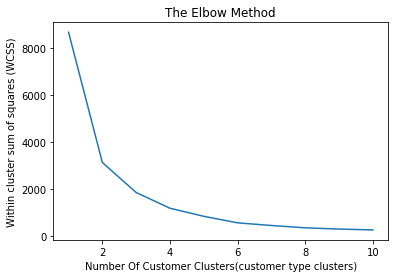

In [119]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)


for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

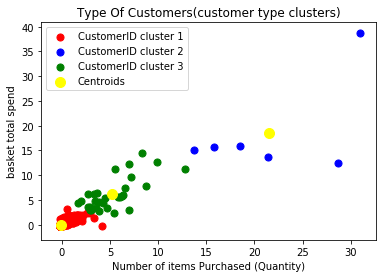

In [120]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

### Clustering appears to separate the customers based on  total spend and numbers of items which would be expected

In [121]:
X = cust_table.iloc[:, [2,1]].values


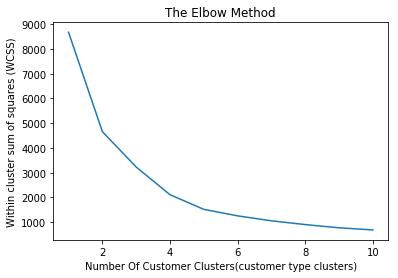

In [122]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)



for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

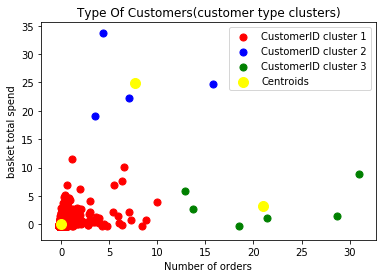

In [123]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of orders')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

### Clustering appears to separate the customers based on  total amount and numbers of orders spend by customer.

In [124]:
X = cust_table.iloc[:, [1,3]].values

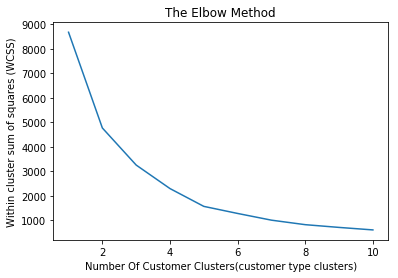

In [125]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)


for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

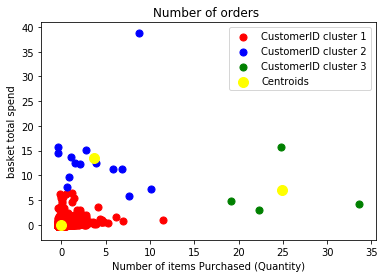

In [126]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Number of orders ')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

### Clustering appears to separate the customers based on Number of orders and Number of items

## Clustering on basis of Product Description

In [127]:
sales_ff['product description'].nunique()

3877

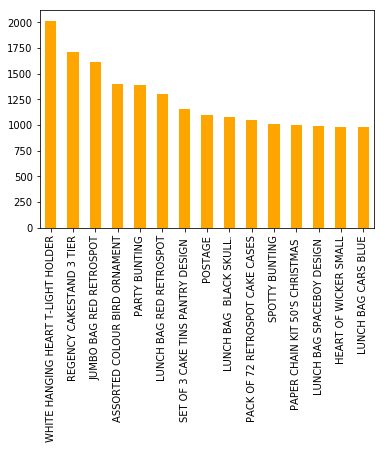

In [128]:
sales_ff['product description'].value_counts().head(15).plot('bar',color='orange')

### we can see that some descriptions correspond to a similar product type. We can see the multiple occurences of lunch bags. We often have color information about the product as well. Furthermore the most common descriptions seem to confirm that the retailer sells various different kinds of products. 

In [129]:
recod_df = pd.get_dummies(sales_ff[['product description', 'transaction country']], drop_first = True)
dfc = pd.concat([sales_ff, recod_df], axis=1)
dfc = dfc.drop(['transaction id', 'product id', 'product description', 'transaction country',  'transaction timestamp','customer id'], axis=1)

In [130]:
dfc.head()

,year_month,month,day,hour,year,quantity sold,unit price,Amount,product description_ 50'S CHRISTMAS GIFT BAG LARGE,product description_ DOLLY GIRL BEAKER,...,transaction country_RSA,transaction country_Saudi Arabia,transaction country_Singapore,transaction country_Spain,transaction country_Sweden,transaction country_Switzerland,transaction country_USA,transaction country_United Arab Emirates,transaction country_United Kingdom,transaction country_Unspecified
0,201012,12,2,8,2010,6,2.55,15.30,0,0,...,0,0,0,0,0,0,0,0,1,0
1,201012,12,2,8,2010,6,3.39,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0
2,201012,12,2,8,2010,8,2.75,22.00,0,0,...,0,0,0,0,0,0,0,0,1,0
3,201012,12,2,8,2010,6,3.39,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0
4,201012,12,2,8,2010,6,3.39,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0


In [131]:
from sklearn.preprocessing import normalize

a = dfc[['quantity sold', 'unit price', 'Amount']]
dfc_scaled = normalize(a)
dfc_scaled = pd.DataFrame(dfc_scaled, columns=a.columns)
dfc_scaled.head(1)

,quantity sold,unit price,Amount
0,0.360771,0.153327,0.919965


In [132]:
X = dfc_scaled.drop('Amount', axis=1)
y1 = dfc_scaled[['Amount']]

In [133]:
kms = KMeans(n_clusters=3, random_state=1).fit(X) #kmeans fitting to have our model
predict = kms.predict(X) #predicting
ctds = kms.cluster_centers_

In [134]:
from wordcloud import WordCloud, STOPWORDS

df_word1 = sales_ff[predict == 0]['product description']
df_word2 = sales_ff[predict == 1]['product description']
df_word3 = sales_ff[predict == 2]['product description']


patchwork1 = " ".join(word for word in df_word1)
patchwork2 = " ".join(word for word in df_word2)
patchwork3 = " ".join(word for word in df_word3)


# Generate a word cloud image
wordcloud1 = WordCloud(background_color="white").generate(patchwork1)
wordcloud2 = WordCloud(background_color="white").generate(patchwork2)
wordcloud3 = WordCloud(background_color="white").generate(patchwork3)


Text(0.5,1,'Cluster 3 : Home furnitures ')

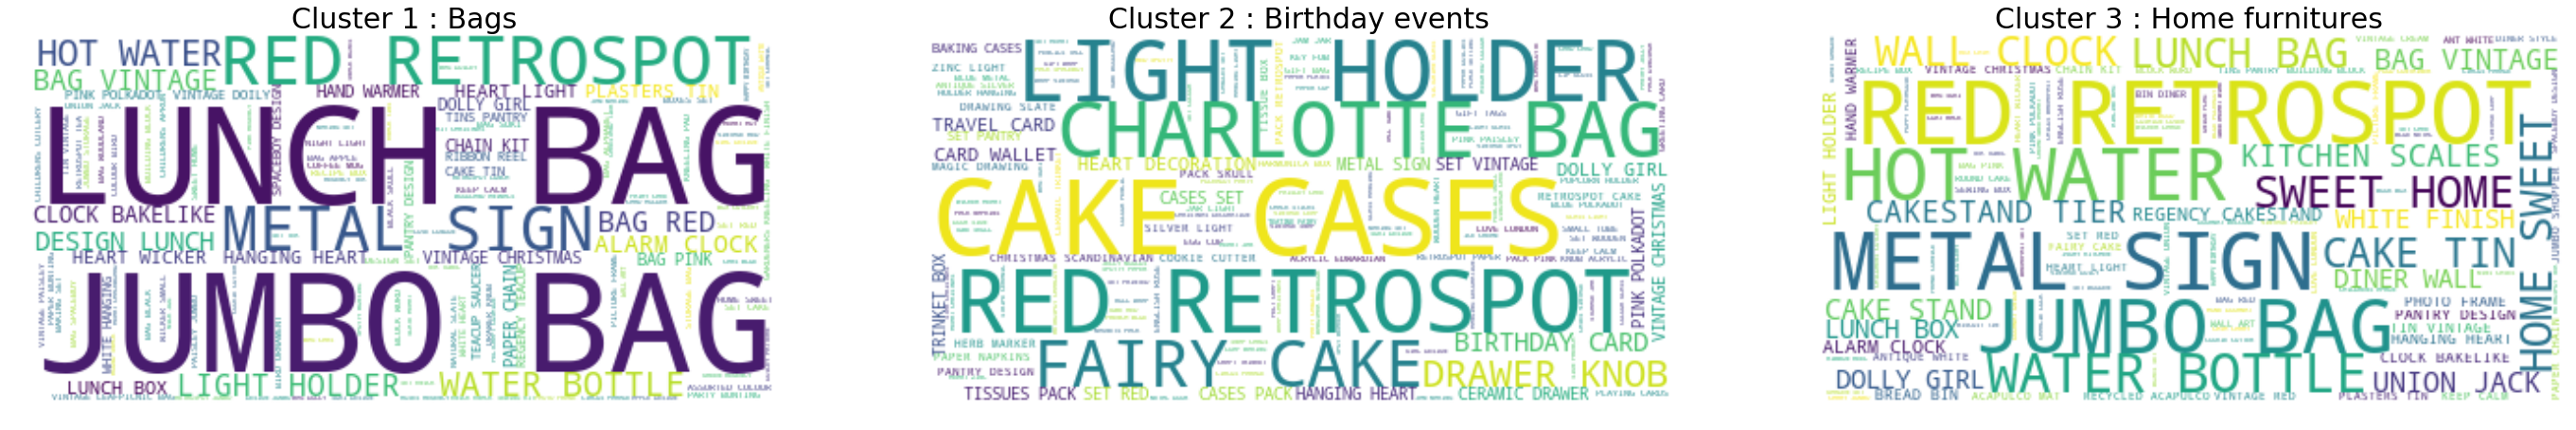

In [135]:
#plot each cluster
plt.figure(figsize=(48, 12))
plt.subplots_adjust(top=1.2)

plt.subplot(131)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.title('Cluster 1 : Bags', fontsize=30)
plt.subplot(132)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Cluster 2 : Birthday events', fontsize=30)
plt.subplot(133)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.title('Cluster 3 : Home furnitures ', fontsize=30)


## Cohort Analysis for Retention of Users

In [136]:
df=sales_ff.copy()

In [137]:
import datetime as dt
def get_month(x):
    return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['transaction timestamp'].apply(get_month)

In [138]:
grouping = df.groupby('customer id')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [139]:
df.head()

,transaction id,product id,year_month,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount,InvoiceMonth,CohortMonth
0,536365,85123A,201012,WHITE HANGING HEART T-LIGHT HOLDER,12,2,8,2010,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,201012,WHITE METAL LANTERN,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,201012,CREAM CUPID HEARTS COAT HANGER,12,2,8,2010,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,201012,KNITTED UNION FLAG HOT WATER BOTTLE,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,201012,RED WOOLLY HOTTIE WHITE HEART.,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [140]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff + 1 
df.head()

,transaction id,product id,year_month,product description,month,day,hour,year,quantity sold,transaction timestamp,unit price,customer id,transaction country,Amount,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,201012,WHITE HANGING HEART T-LIGHT HOLDER,12,2,8,2010,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,201012,WHITE METAL LANTERN,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,201012,CREAM CUPID HEARTS COAT HANGER,12,2,8,2010,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,201012,KNITTED UNION FLAG HOT WATER BOTTLE,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,201012,RED WOOLLY HOTTIE WHITE HEART.,12,2,8,2010,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


##  First Cohort: User number & Retention Rate(Number of active users)


In [141]:
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['customer id'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot_table(index = 'CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'customer id')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### From the result above, the first column in the chart is active user number on that specific month, and the following columns show how the many remaining users are still using the service on the second, third, and fourth month.

In [142]:
# Retention table
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### The first column is  100% retention rate, and with time going by, the retention rate would drop.

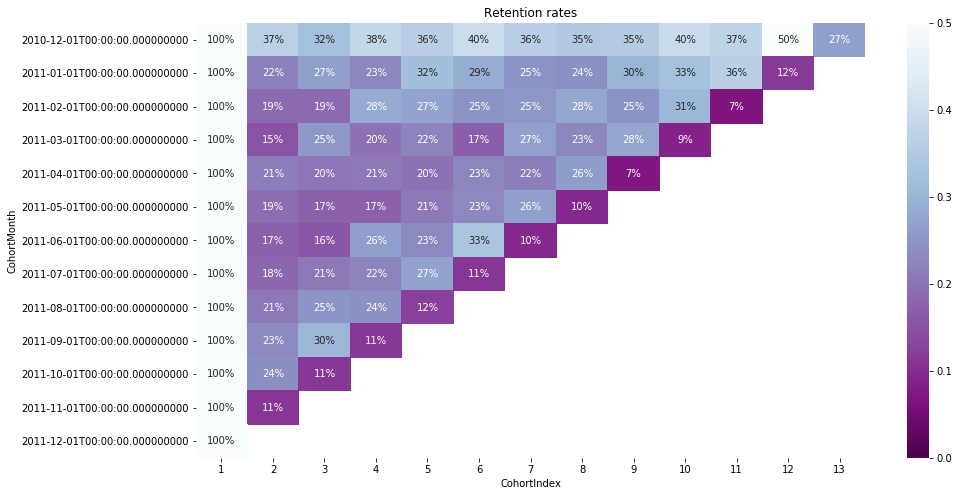

In [143]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

### Customer retention is a very useful metric to understand how many of the all customers are still active.Retention gives you the percentage of active customers compared to the total number of customers.

In [146]:
quan=sales_ff.groupby(['year_month','product id'])['quantity sold'].sum()
quan

year_month  product id  
201012      10002            224
            10120             16
            10125            143
            10133            123
            10135            366
            11001             65
            15034             38
            15036            132
            15039             17
            16008             14
            16010             12
            16011             94
            16012            120
            16014           1029
            16015             21
            16016             28
            16033            240
            16045            100
            16046             10
            16048             24
            16054              2
            16216             20
            16218              5
            16219             12
            16225            262
            16235            111
            16236             41
            16237            564
            16238             57
            17003 

In [147]:
quan_final=quan.to_frame()
quan_final

quantity sold
year_month product id                 
201012     10002                   224
           10120                    16
           10125                   143
           10133                   123
           10135                   366
           11001                    65
           15034                    38
           15036                   132
           15039                    17
           16008                    14
           16010                    12
           16011                    94
           16012                   120
           16014                  1029
           16015                    21
           16016                    28
           16033                   240
           16045                   100
           16046                    10
           16048                    24
           16054                     2
           16216                    20
           16218                     5
           16219                    12
           16225                   262
           16235                   111
           16236                    41
           16237                   564
           16238                    57
           17003                  1119
...                                ...
201112     90210C                   20
           90214A                   24
           90214B                   12
           90214C                   26
           90214D                   24
           90214E                   25
           90214F                   13
           90214G                   25
           90214H                   13
           90214I                   13
           90214J                   12
           90214K                   25
           90214L                   36
           90214M                   12
           90214N                   13
           90214O                   12
           90214P                   25
           90214R                   13
           90214S                   25
           90214T                   12
           90214U                   12
           90214V                   12
           90214W                   12
           90214Y                   60
           90214Z                   12
           BANK CHARGES              1
           C2                        3
           DOT                       1
           M                       819
           POST                    123

[30407 rows x 1 columns]